In [19]:
# Step 1: Data Cleaning - Handle Missing Values with Median Imputation
import pandas as pd
import kagglehub

# Download the dataset from Kaggle
dataset_path = kagglehub.dataset_download('devanshibavaria/water-potability-dataset-with-10-parameteres')
dataset_path = kagglehub.dataset_download('devanshibavaria/water-potability-dataset-with-10-parameteres')

# Load the dataset
csv_path = f"{dataset_path}/water_potability.csv"  # adjust if the file name is different
df = pd.read_csv(csv_path)

# Check for missing values (for reporting purposes)
print("Missing values before cleaning:\n", df.isnull().sum())

# Fill missing values using median (robust against outliers)
df_cleaned = df.fillna(df.median())

# Confirm all missing values handled
print("Missing values after cleaning:\n", df_cleaned.isnull().sum())


Missing values before cleaning:
 ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64
Missing values after cleaning:
 ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64


In [20]:
# Step 2A: Normalize Data and Apply Kruskal's MST

from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
from scipy.sparse.csgraph import minimum_spanning_tree
import numpy as np

# Drop target label for unsupervised clustering
X = df_cleaned.drop(columns=["Potability"])

# Normalize the feature values (mean=0, std=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Compute pairwise Euclidean distance matrix
distance_matrix = squareform(pdist(X_scaled, metric='euclidean'))

# Construct MST using Kruskal's algorithm
mst_sparse = minimum_spanning_tree(distance_matrix)
mst_matrix = mst_sparse.toarray()

# Preview: Total weight of MST
print("Total weight of MST:", mst_matrix[mst_matrix > 0].sum())


Total weight of MST: 4645.382814026301


/tmp/ipython-input-21-2206487806.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


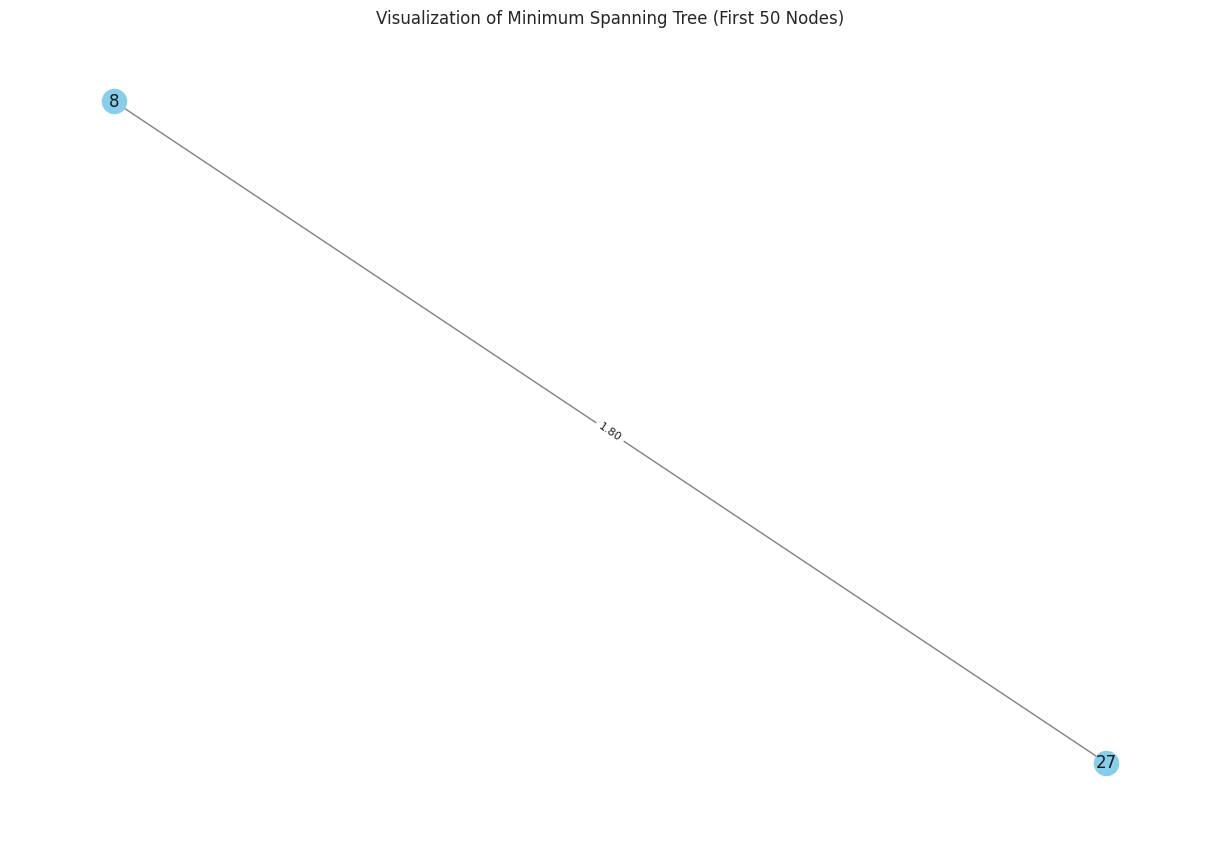

In [21]:
import matplotlib.pyplot as plt
import networkx as nx
from scipy.spatial.distance import pdist, squareform
from scipy.sparse.csgraph import minimum_spanning_tree

# Assuming `X_scaled` is your already normalized feature matrix

# Compute pairwise distance matrix and construct MST
distance_matrix = squareform(pdist(X_scaled, metric='euclidean'))
mst_sparse = minimum_spanning_tree(distance_matrix)
mst_matrix = mst_sparse.toarray()

# Create MST graph for first 50 nodes
G = nx.Graph()
n_nodes = 50
for i in range(n_nodes):
    for j in range(n_nodes):
        if mst_matrix[i, j] > 0:
            G.add_edge(i, j, weight=mst_matrix[i, j])

# Plot the MST
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=300, node_color="skyblue", edge_color="gray")
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels={k: f"{v:.2f}" for k, v in labels.items()}, font_size=8)
plt.title("Visualization of Minimum Spanning Tree (First 50 Nodes)")
plt.axis("off")
plt.tight_layout()
plt.show()


/tmp/ipython-input-22-2126562228.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Potability", y=col, data=df_cleaned, palette="Set2")
/tmp/ipython-input-22-2126562228.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Potability", y=col, data=df_cleaned, palette="Set2")
/tmp/ipython-input-22-2126562228.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Potability", y=col, data=df_cleaned, palette="Set2")
/tmp/ipython-input-22-2126562228.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will

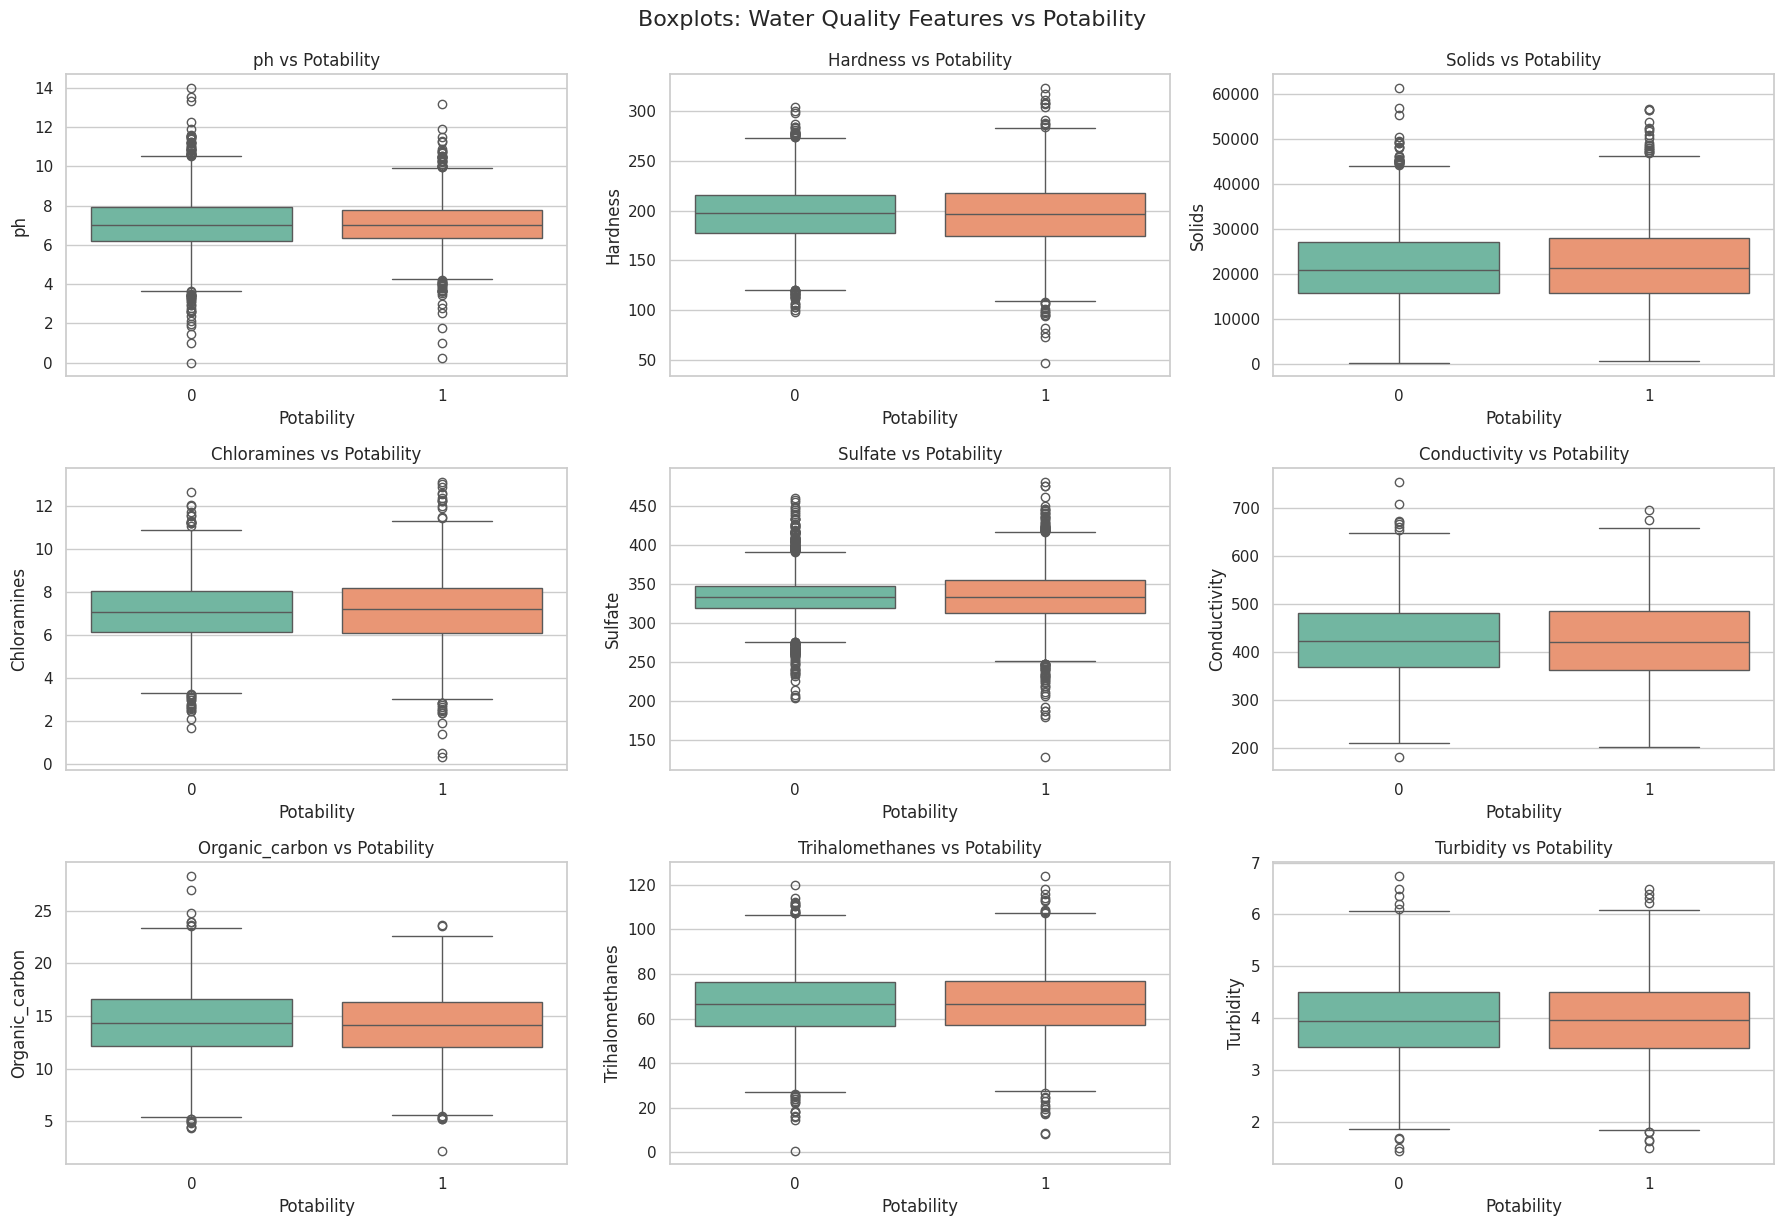

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set visual style
sns.set(style="whitegrid")
plt.figure(figsize=(18, 12))

# Drop target column to iterate over features
features = df_cleaned.columns.drop("Potability")

# Generate boxplots for each feature
for idx, col in enumerate(features, 1):
    plt.subplot(3, 3, idx)
    sns.boxplot(x="Potability", y=col, data=df_cleaned, palette="Set2")
    plt.title(f"{col} vs Potability")

plt.tight_layout()
plt.suptitle("Boxplots: Water Quality Features vs Potability", fontsize=16, y=1.02)
plt.show()


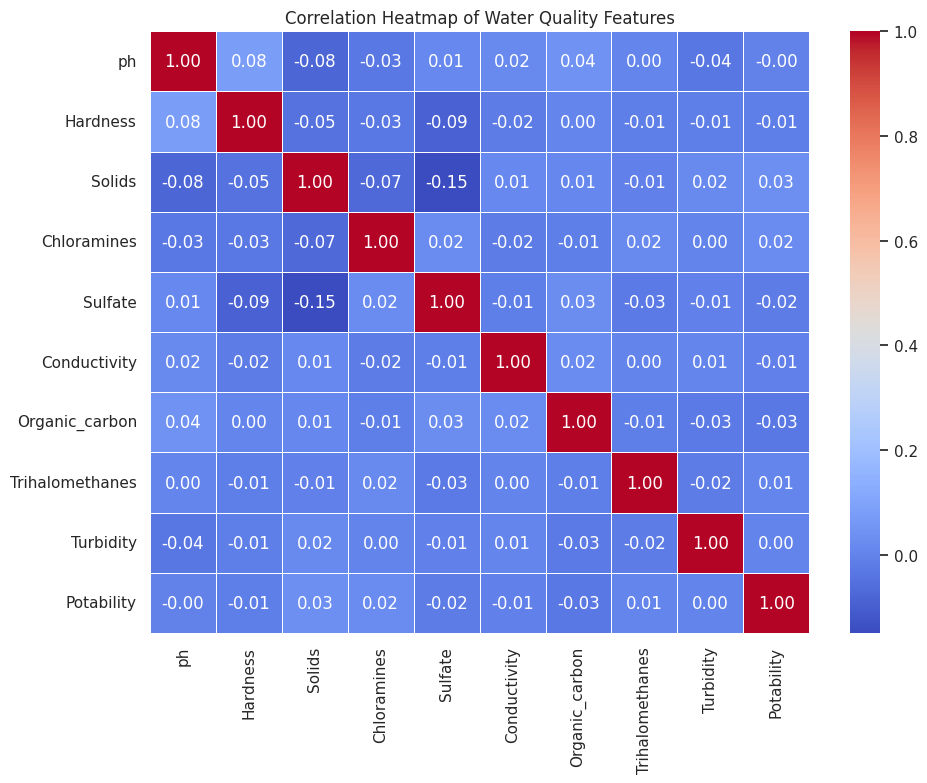

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr_matrix = df_cleaned.corr(numeric_only=True)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Water Quality Features")
plt.tight_layout()
plt.show()


In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Step 1: Separate features and target
X = df_cleaned.drop("Potability", axis=1)
y = df_cleaned["Potability"]

# Step 2: Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [25]:
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy.sparse.csgraph import connected_components
from sklearn.metrics import pairwise_distances
import numpy as np

# Use the normalized dataset without 'Potability' (as done earlier)
X_mst = df_cleaned.drop("Potability", axis=1)
X_scaled = StandardScaler().fit_transform(X_mst)

# Step 1: Compute distance matrix
distance_matrix = pairwise_distances(X_scaled, metric="euclidean")

# Step 2: Build MST
mst = minimum_spanning_tree(distance_matrix)

# Step 3: Convert MST to dense format and sort the edges by weight (for edge removal)
mst_dense = mst.toarray().astype(float)
edges = []
for i in range(len(mst_dense)):
    for j in range(len(mst_dense)):
        if mst_dense[i, j] != 0:
            edges.append((i, j, mst_dense[i, j]))

# Step 4: Sort edges by weight in descending order (to remove longest ones)
edges.sort(key=lambda x: x[2], reverse=True)

# Step 5: Remove the longest k-1 edges (k = 3)
k = 3
edges_to_remove = edges[:k-1]
for i, j, _ in edges_to_remove:
    mst_dense[i][j] = 0

# Step 6: Recompute connected components (clusters)
from scipy.sparse import csr_matrix
mst_pruned = csr_matrix(mst_dense)
n_components, labels = connected_components(csgraph=mst_pruned, directed=False)

# Step 7: Assign cluster labels to the original data
df_clustered = df_cleaned.copy()
df_clustered["MST_Cluster"] = labels

print("Clusters assigned using Kruskal's MST with", k, "clusters.")
df_clustered["MST_Cluster"].value_counts()


Clusters assigned using Kruskal's MST with 3 clusters.


,count
MST_Cluster,
0,3274
1,1
2,1


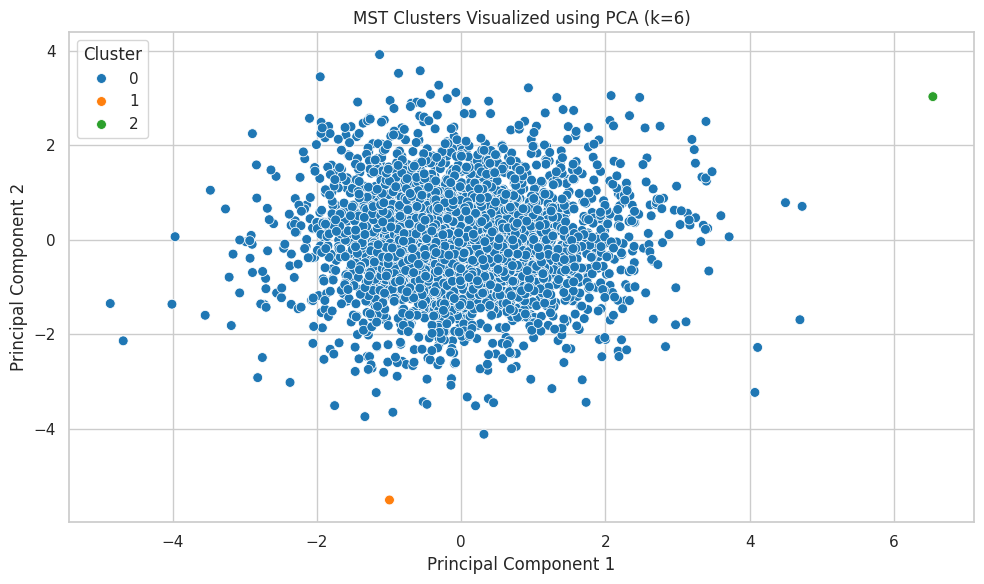

In [26]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Add PCA results to clustered DataFrame
df_clustered["PCA1"] = X_pca[:, 0]
df_clustered["PCA2"] = X_pca[:, 1]

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="PCA1", y="PCA2",
    hue="MST_Cluster",
    data=df_clustered,
    palette="tab10",
    s=50
)
plt.title("MST Clusters Visualized using PCA (k=6)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


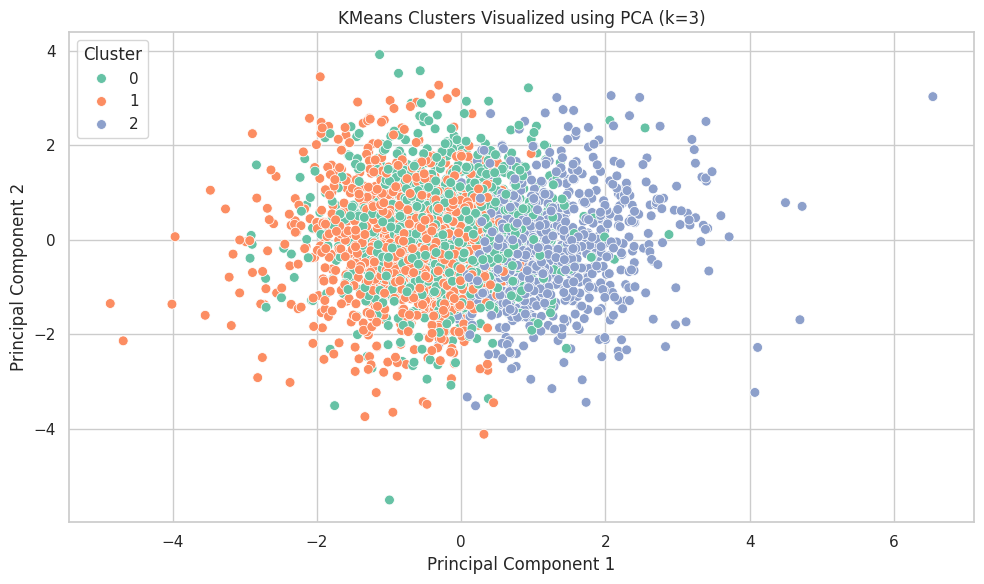

In [27]:
from sklearn.cluster import KMeans

# Try with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

df_clustered["KMeans_Cluster"] = kmeans_labels

# Visualize with PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="PCA1", y="PCA2",
    hue="KMeans_Cluster",
    data=df_clustered,
    palette="Set2",
    s=50
)
plt.title("KMeans Clusters Visualized using PCA (k=3)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


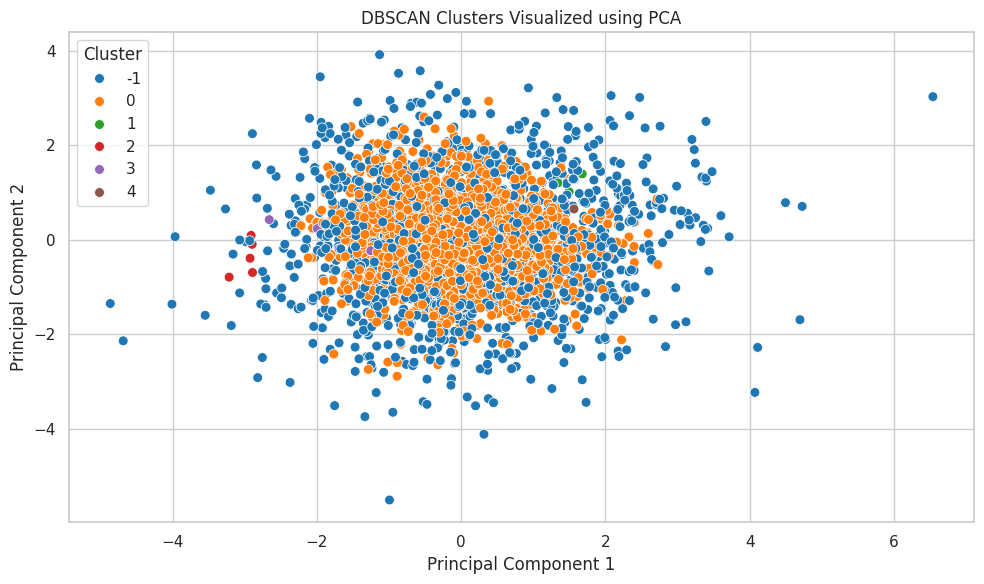

In [28]:
from sklearn.cluster import DBSCAN

# DBSCAN with eps (distance threshold) and min_samples (minimum points to form dense region)
dbscan = DBSCAN(eps=1.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

df_clustered["DBSCAN_Cluster"] = dbscan_labels

# Visualize with PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="PCA1", y="PCA2",
    hue="DBSCAN_Cluster",
    data=df_clustered,
    palette="tab10",
    s=50
)
plt.title("DBSCAN Clusters Visualized using PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


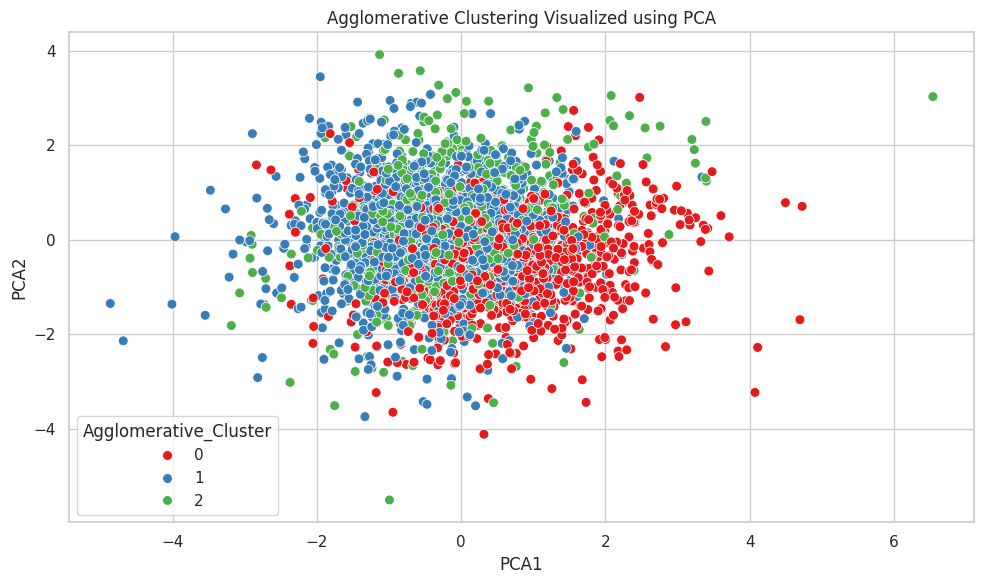

In [29]:
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters=3)
agg_labels = agg.fit_predict(X_scaled)

df_clustered["Agglomerative_Cluster"] = agg_labels

# Visualize
plt.figure(figsize=(10, 6))
sns.scatterplot(x="PCA1", y="PCA2", hue="Agglomerative_Cluster", data=df_clustered, palette="Set1", s=50)
plt.title("Agglomerative Clustering Visualized using PCA")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.tight_layout()
plt.show()


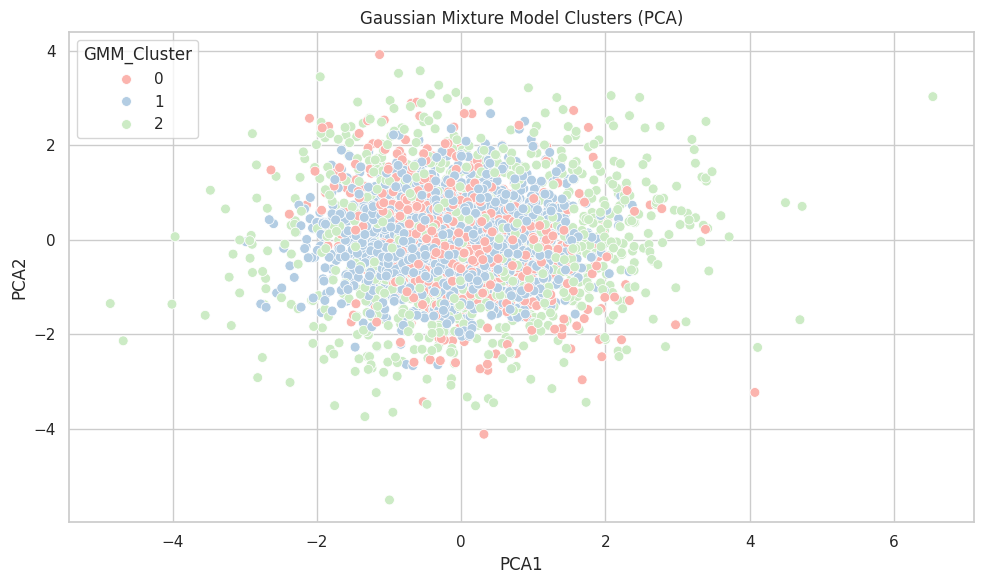

In [30]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, random_state=42)
gmm_labels = gmm.fit_predict(X_scaled)

df_clustered["GMM_Cluster"] = gmm_labels

# Visualize
plt.figure(figsize=(10, 6))
sns.scatterplot(x="PCA1", y="PCA2", hue="GMM_Cluster", data=df_clustered, palette="Pastel1", s=50)
plt.title("Gaussian Mixture Model Clusters (PCA)")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.tight_layout()
plt.show()


In [31]:
# Generate size summaries
cluster_counts = {
    "MST (k=6)": df_clustered["MST_Cluster"].value_counts().sort_index(),
    "KMeans (k=3)": df_clustered["KMeans_Cluster"].value_counts().sort_index(),
    "DBSCAN": df_clustered["DBSCAN_Cluster"].value_counts().sort_index(),
    "Agglomerative (k=3)": df_clustered["Agglomerative_Cluster"].value_counts().sort_index() if "Agglomerative_Cluster" in df_clustered else None,
    "GMM (k=3)": df_clustered["GMM_Cluster"].value_counts().sort_index() if "GMM_Cluster" in df_clustered else None
}

# Combine into a DataFrame
import pandas as pd

cluster_table = pd.DataFrame(cluster_counts)
cluster_table.fillna("-", inplace=True)  # replace missing algos if not run
print(cluster_table)


   MST (k=6) KMeans (k=3)  DBSCAN Agglomerative (k=3) GMM (k=3)
-1         -            -    1381                   -         -
 0    3274.0       1175.0    1877               952.0     790.0
 1       1.0       1184.0       5              1606.0    1535.0
 2       1.0        917.0       5               718.0     951.0
 3         -            -       4                   -         -
 4         -            -       4                   -         -


/tmp/ipython-input-31-671760055.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  cluster_table.fillna("-", inplace=True)  # replace missing algos if not run


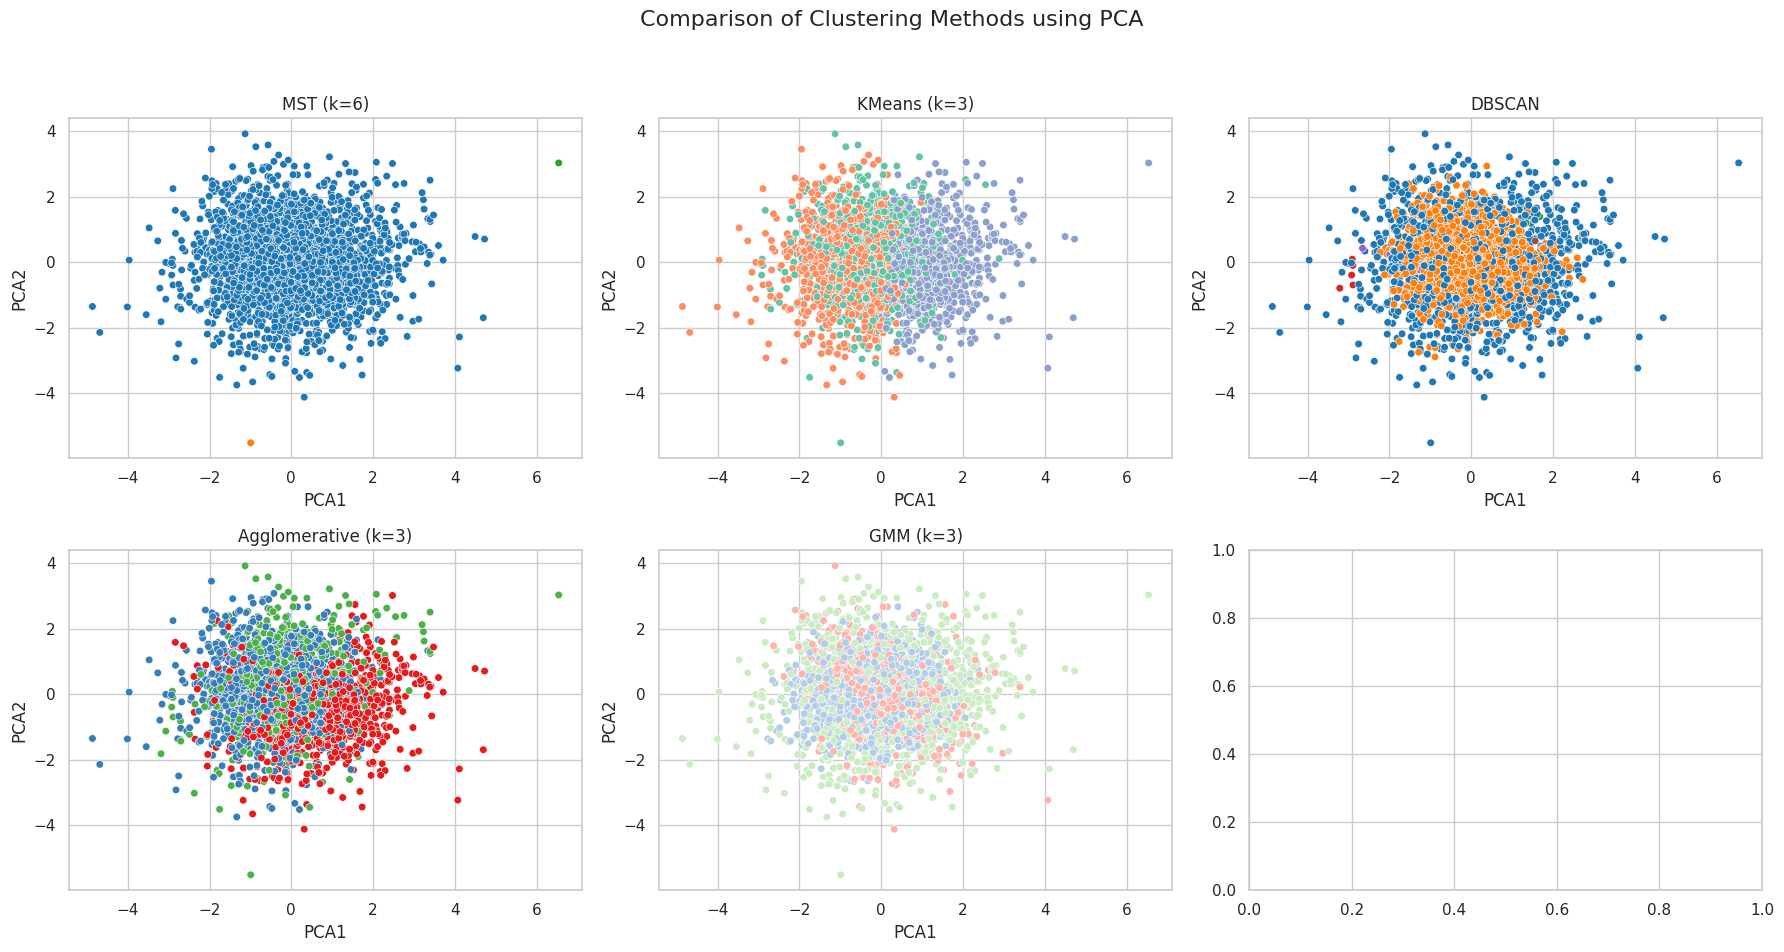

In [32]:
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle("Comparison of Clustering Methods using PCA", fontsize=16)

clustering_algos = [
    ("MST_Cluster", "MST (k=6)", "tab10"),
    ("KMeans_Cluster", "KMeans (k=3)", "Set2"),
    ("DBSCAN_Cluster", "DBSCAN", "tab10"),
    ("Agglomerative_Cluster", "Agglomerative (k=3)", "Set1"),
    ("GMM_Cluster", "GMM (k=3)", "Pastel1")
]

for i, (col, title, palette) in enumerate(clustering_algos):
    if col in df_clustered.columns:
        ax = axs[i//3][i%3]
        sns.scatterplot(
            x="PCA1", y="PCA2",
            hue=col,
            data=df_clustered,
            palette=palette,
            ax=ax,
            s=30,
            legend=False
        )
        ax.set_title(title)
        ax.set_xlabel("PCA1")
        ax.set_ylabel("PCA2")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


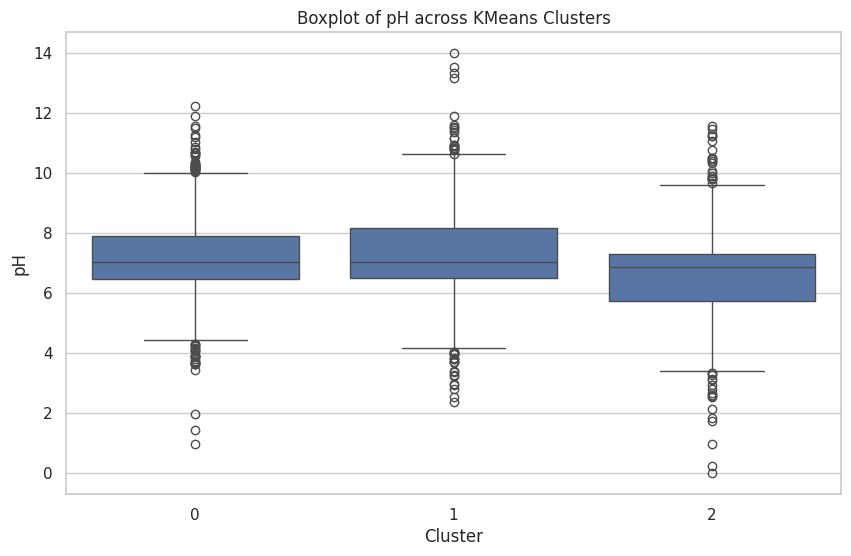

In [33]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="KMeans_Cluster", y="ph", data=df_clustered)
plt.title("Boxplot of pH across KMeans Clusters")
plt.xlabel("Cluster")
plt.ylabel("pH")
plt.show()


In [34]:
plt.savefig("kmeans_clusters_pca.png", dpi=300, bbox_inches='tight')
plt.savefig("boxplot_ph_kmeans.png", dpi=300, bbox_inches='tight')


<Figure size 640x480 with 0 Axes>

Accuracy: 0.6737804878048781

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.85      0.77       412
           1       0.60      0.38      0.46       244

    accuracy                           0.67       656
   macro avg       0.65      0.61      0.61       656
weighted avg       0.66      0.67      0.65       656



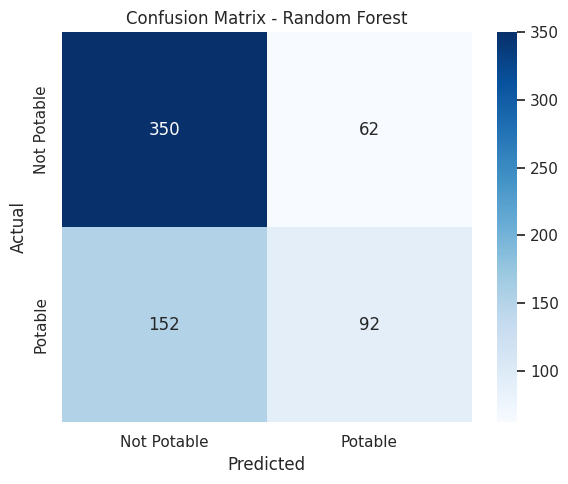

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Train the model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Step 2: Make predictions
y_pred = rf_model.predict(X_test_scaled)

# Step 3: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Step 4: Confusion matrix plot
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Potable", "Potable"], yticklabels=["Not Potable", "Potable"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.tight_layout()
plt.show()


In [36]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 67.38%

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.85      0.77       412
           1       0.60      0.38      0.46       244

    accuracy                           0.67       656
   macro avg       0.65      0.61      0.61       656
weighted avg       0.66      0.67      0.65       656

